Loaded Species Tree with 20 nodes.
Found 230 unique transfer paths.


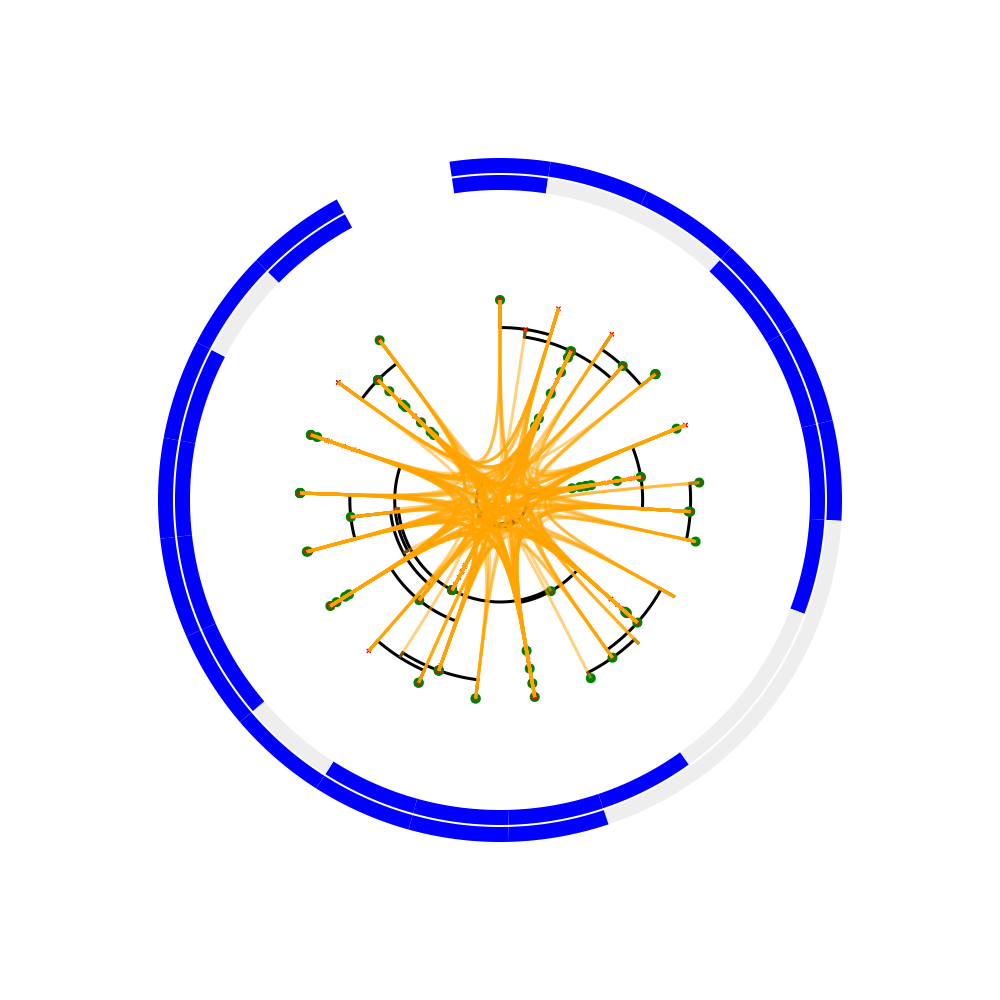

In [1]:
import phylustrator as ph
import phylustrator.zombi_parser as zp

# 1. Parse Zombi Output
# -----------------------------
# Point this to the parent folder containing "T" and "G"
zombi_data = zp.parse_zombi("/Users/aadria/Desktop/Github/ZOMBI/Output_folder")


print(f"Loaded Species Tree with {len(zombi_data.species_tree)} nodes.")
print(f"Found {len(zombi_data.transfers)} unique transfer paths.")

# 2. Setup Drawer
# -----------------------------
style = ph.TreeStyle(radius=200, node_size=0, branch_size=3, leaf_size=0, degrees=340)
drawer = ph.RadialTreeDrawer(zombi_data.species_tree, style=style)

# 3. Draw Base Tree (Colored by Total Transfers?)
# -----------------------------
# Let's highlight branches that are "Hotspots" for donating genes
stats_map = zombi_data.aggregated_stats.set_index("species").to_dict(orient="index")


drawer.draw()

# 4. Add Transfer Curves
# -----------------------------
# Zombi transfers have integer frequencies (e.g., 50 events).
# We can normalize opacity so 1 event is faint, 50 is solid.
max_freq = max([t['freq'] for t in zombi_data.transfers]) if zombi_data.transfers else 1

# Custom opacity scaler
# freq / max_freq might be too faint for small numbers. Let's try a log scale or simple multiplier.
#drawer.add_transfer_links(
#    zombi_data.transfers,
#    gradient_colors=("gold", "darkred"), # Gold (Source) -> Red (Target)
#    opacity_scale=1.0 / max_freq * 2.0,  # Tuning factor
#    curve_factor=0.5
#)

# 5. Add Heatmap (Duplications/Losses)
# -----------------------------
heatmap_data = {}
for n in zombi_data.species_tree.get_leaves():
    if n.name in stats_map:
        heatmap_data[n.name] = {
            "Dup": stats_map[n.name]['duplications'],
            "Loss": stats_map[n.name]['losses']
        }

drawer.add_heatmap_matrix(heatmap_data, columns=["Dup", "Loss"], start_radius=310, ring_width=15, cmap=lambda x: "blue" if x > 0 else "#eee")
drawer.mark_events(zombi_data.raw_events, type_filter="D", color="green", size=5)
drawer.mark_events(zombi_data.raw_events, type_filter="L", color="red", shape="x", size=2)
drawer.add_transfer_links(zombi_data.transfers, curve_factor=1., opacity_scale=0.5)
#drawer.save_figure("zombi_simulation.svg")
display(drawer.d)

Figure saved to zombi_linear_chronogram.svg


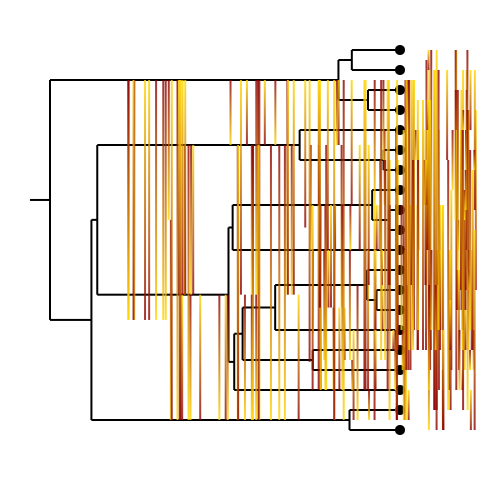

In [4]:
import phylustrator as ph

# Use Vertical Drawer
v_style = ph.TreeStyle(width=500, height=500, node_size=0, branch_size=2)
v_drawer = ph.VerticalTreeDrawer(zombi_data.species_tree, style=v_style)
v_drawer.draw()

# 1. Exact Events
#v_drawer.mark_events(zombi_data.raw_events, type_filter="D", color="green", size=3)
#v_drawer.mark_events(zombi_data.raw_events, type_filter="L", color="red", shape="x", size=3)

# 2. Exact Transfers (Sigmoid Curves)
v_drawer.add_transfer_links(
    zombi_data.transfers, 
    gradient_colors=("gold", "darkred"),
    opacity_scale=0.8
)

# 3. Heatmap Matrix (works same as before)
# ... add_heatmap_matrix ...

v_drawer.save_figure("zombi_linear_chronogram.svg")
display(v_drawer.d)

In [9]:
def diagnose_transfer_times(drawer, transfers):
    print(f"{'ID':<4} | {'Type':<10} | {'Branch Span (Time)':<25} | {'Event Time':<12} | {'Verdict'}")
    print("-" * 80)
    
    # Build lookup
    name2node = {n.name: n for n in drawer.t.traverse()}
    
    for i, tr in enumerate(transfers[:15]): # Check first 15
        if 'time' not in tr:
            print(f"{i:<4} | ALE/NoTime | {'-':<25} | {'-':<12} | Use Midpoint")
            continue
            
        event_t = tr['time']
        node = name2node.get(tr['from'])
        
        if not node:
            print(f"{i:<4} | Error      | Node {tr['from']} not found")
            continue
            
        # Calculate Branch Span
        end_t = node.dist_to_root
        start_t = node.up.dist_to_root if node.up else 0
        
        # Check alignment
        if abs(event_t - end_t) < 1e-4:
            status = "EXACTLY AT NODE (Speciation)"
        elif abs(event_t - start_t) < 1e-4:
            status = "EXACTLY AT START"
        elif start_t < event_t < end_t:
            status = "On Branch (OK)"
        elif event_t > end_t:
            diff = event_t - end_t
            status = f"GHOST (Past tip by {diff:.4f})"
        else:
            diff = start_t - event_t
            status = f"EARLY (Before branch by {diff:.4f})"
            
        print(f"{i:<4} | Zombi      | {start_t:.4f} -> {end_t:.4f}          | {event_t:.4f}       | {status}")

# Run it
diagnose_transfer_times(v_drawer, zombi_data.transfers)

ID   | Type       | Branch Span (Time)        | Event Time   | Verdict
--------------------------------------------------------------------------------
0    | Zombi      | 0.3485 -> 1.3163          | 0.9748       | On Branch (OK)
1    | Zombi      | 0.3485 -> 1.3163          | 0.9947       | On Branch (OK)
2    | Zombi      | 0.3485 -> 1.3163          | 1.0405       | On Branch (OK)
3    | Zombi      | 0.3485 -> 1.3163          | 1.1077       | On Branch (OK)
4    | Zombi      | 0.3485 -> 1.3163          | 1.2957       | On Branch (OK)
5    | Zombi      | 0.3485 -> 1.3163          | 1.4884       | GHOST (Past tip by 0.1721)
6    | Zombi      | 0.3485 -> 1.3163          | 1.4957       | GHOST (Past tip by 0.1795)
7    | Zombi      | 0.3485 -> 1.3163          | 1.5212       | GHOST (Past tip by 0.2050)
8    | Zombi      | 0.3485 -> 1.3163          | 1.5342       | GHOST (Past tip by 0.2179)
9    | Zombi      | 0.3485 -> 1.3163          | 1.7504       | GHOST (Past tip by 0.4341)
10   | Z

In [6]:
def debug_zombi_alignment(drawer, zombi_data):
    """
     audits the alignment between Zombi event times and the TreeDrawer coordinates.
    """
    print(f"--- DEBUG REPORT ---")
    print(f"Tree Root X: {drawer.root_x}")
    print(f"Scaling Factor: {drawer.sf}")
    
    t = zombi_data.species_tree
    # Map names to nodes
    name2node = {n.name: n for n in t.traverse()}
    
    slanted_count = 0
    miss_source_count = 0
    miss_target_count = 0
    node_clashes = 0
    
    print("\nChecking first 10 transfers...")
    
    for i, tr in enumerate(zombi_data.transfers):
        if i >= 10: break # Only check first 10 for verbosity
        
        event_time = tr.get('time')
        if event_time is None:
            print(f"Skipping transfer {i}: No time data.")
            continue
            
        src = name2node.get(tr['from'])
        tgt = name2node.get(tr['to'])
        
        if not src or not tgt:
            print(f"Transfer {i}: Node not found in tree.")
            continue
            
        # Get Branch Time Spans (Time = Distance to Root)
        # Note: Root is Time 0
        src_start_t = src.up.dist_to_root if src.up else 0
        src_end_t = src.dist_to_root
        
        tgt_start_t = tgt.up.dist_to_root if tgt.up else 0
        tgt_end_t = tgt.dist_to_root
        
        # Check Source
        if not (src_start_t <= event_time <= src_end_t):
            print(f"[!] SOURCE MISMATCH T={event_time:.4f}")
            print(f"    Branch {src.name}: {src_start_t:.4f} -> {src_end_t:.4f}")
            print(f"    Diff: {event_time - src_end_t:.4f}")
            miss_source_count += 1
            
        # Check Target
        if not (tgt_start_t <= event_time <= tgt_end_t):
            print(f"[!] TARGET MISMATCH T={event_time:.4f}")
            print(f"    Branch {tgt.name}: {tgt_start_t:.4f} -> {tgt_end_t:.4f}")
            miss_target_count += 1

        # Check Node Clashes (Visualizing "Leaving from node")
        # If event is within 0.001 of the branch end, it looks like it's on the node
        if abs(event_time - src_end_t) < 0.0001:
            print(f"[*] ON NODE TIP: Transfer leaves exactly at end of branch {src.name}")
            node_clashes += 1

    print(f"\n--- SUMMARY ---")
    print(f"Total Transfers: {len(zombi_data.transfers)}")
    if miss_source_count > 0:
        print(f"WARNING: {miss_source_count} transfers start OUTSIDE their source branch time-span.")
    if miss_target_count > 0:
        print(f"WARNING: {miss_target_count} transfers arrive OUTSIDE their target branch time-span.")
    if node_clashes > 0:
        print(f"INFO: {node_clashes} transfers happen exactly at speciation events (will look like node links).")

# Run it
debug_zombi_alignment(v_drawer, zombi_data)

--- DEBUG REPORT ---
Tree Root X: -200.0
Scaling Factor: 135.600191436476

Checking first 10 transfers...
[!] SOURCE MISMATCH T=1.4884
    Branch n6: 0.3485 -> 1.3163
    Diff: 0.1721
[!] SOURCE MISMATCH T=1.4957
    Branch n6: 0.3485 -> 1.3163
    Diff: 0.1795
[!] SOURCE MISMATCH T=1.5212
    Branch n6: 0.3485 -> 1.3163
    Diff: 0.2050
[!] SOURCE MISMATCH T=1.5342
    Branch n6: 0.3485 -> 1.3163
    Diff: 0.2179
[!] SOURCE MISMATCH T=1.7504
    Branch n6: 0.3485 -> 1.3163
    Diff: 0.4341

--- SUMMARY ---
Total Transfers: 230


ZombiData(species_tree=Tree node 'Root' (0x10f4effd), raw_events=[{'time': 0.9518445994169513, 'type': 'L', 'node': 'n6'}, {'time': 0.9747533742953447, 'type': 'T', 'node': 'n6', 'to_node': 'n4'}, {'time': 0.9775356635500281, 'type': 'L', 'node': 'n6'}, {'time': 0.9947214428488811, 'type': 'T', 'node': 'n6', 'to_node': 'n5'}, {'time': 1.0358971138695519, 'type': 'L', 'node': 'n6'}, {'time': 1.0405102101524555, 'type': 'T', 'node': 'n6', 'to_node': 'n5'}, {'time': 1.0562517298896479, 'type': 'L', 'node': 'n6'}, {'time': 1.1077226250825836, 'type': 'T', 'node': 'n6', 'to_node': 'n4'}, {'time': 1.131132888231012, 'type': 'L', 'node': 'n6'}, {'time': 1.2342705368993974, 'type': 'L', 'node': 'n6'}, {'time': 1.2957482334528752, 'type': 'T', 'node': 'n6', 'to_node': 'n4'}, {'time': 1.4081929579955947, 'type': 'L', 'node': 'n6'}, {'time': 1.4322307807050674, 'type': 'L', 'node': 'n6'}, {'time': 1.4376162499079521, 'type': 'L', 'node': 'n6'}, {'time': 1.4508584104496542, 'type': 'L', 'node': 'n